In [2]:
import tensorflow as tf

tf.random.set_seed(42)
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from official.legacy.image_classification.augment import RandAugment
import tensorflow_datasets as tfds


In [3]:
#prepare the data
# source data : mnist, target data:svhn
(
    (mnist_x_train, mnist_y_train),
    (mnist_x_test, mnist_y_test)
) = keras.datasets.mnist.load_data()

# add a channel dimension
mnist_x_train = tf.expand_dims(mnist_x_train, -1)
mnist_x_test = tf.expand_dims(mnist_x_test, -1)

mnist_y_train = tf.one_hot(mnist_y_train, 10).numpy()

svhn_train, svhn_test = tfds.load(
    'svhn_cropped', split=['train', 'test'], as_supervised=True,
)

In [4]:
resize = 32

source_batch_size = 64
target_batch_size = 3 * source_batch_size # the batch size ratio is a tuning point
epochs = 10
steps_per_epoch = len(mnist_x_train) // source_batch_size
total_steps = epochs * steps_per_epoch

auto = tf.data.AUTOTUNE
learning_rate = 0.03

weight_decay = 0.0005
init = 'he_normal'
depth = 28
width_mult = 2

In [5]:
# data augmentation

augmenter = RandAugment(num_layers = 2, magnitude = 5)

def weak_augment(image, source=True):
    if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)

    if source:
        image = tf.image.resize_with_pad(image, resize, resize)
        image = tf.tile(image, [1, 1, 3])

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (resize, resize, 3))

    return image

def strong_augment(image, source=True):
    if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)

    if source:
        image = tf.image.resize_with_pad(image, resize, resize)
        image = tf.tile(image, [1, 1, 3])
    image = augmenter.distort(image)
    return image


In [6]:
def create_individual_ds(ds, aug_func, source=True):
    if source:
        batch_size = source_batch_size
    else:
        batch_size = target_batch_size
    ds = ds.shuffle(batch_size * 10, seed= 42)

    if source:
        ds = ds.map(lambda x, y : (aug_func(x), y), num_parallel_calls = auto)
    else:
        ds = ds.map(lambda x, y : (aug_func(x, False), y), num_parallel_calls = auto)

    ds = ds.batch(batch_size).prefetch(auto)

    return ds

In [7]:
# build dataset

source_ds = tf.data.Dataset.from_tensor_slices((mnist_x_train, mnist_y_train))
source_ds_w = create_individual_ds(source_ds, weak_augment)
source_ds_s = create_individual_ds(source_ds, strong_augment)
final_source_ds = tf.data.Dataset.zip((source_ds_w, source_ds_s))

target_ds_w = create_individual_ds(svhn_train, weak_augment, source=False)
target_ds_s = create_individual_ds(svhn_train, strong_augment, source=False)

final_target_ds = tf.data.Dataset.zip((target_ds_w, target_ds_s))

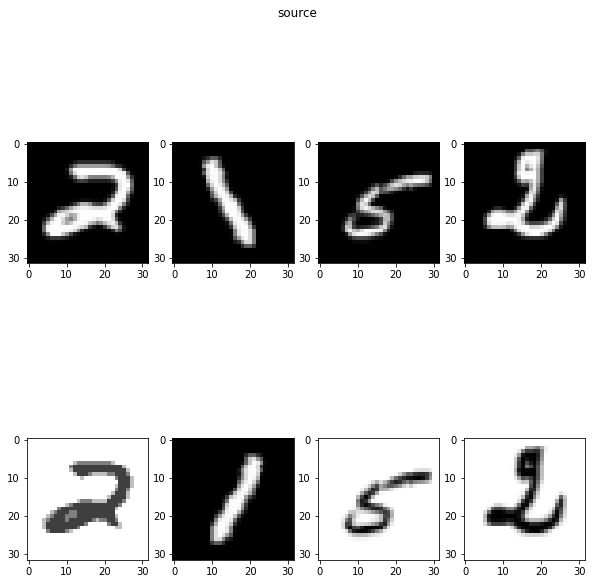

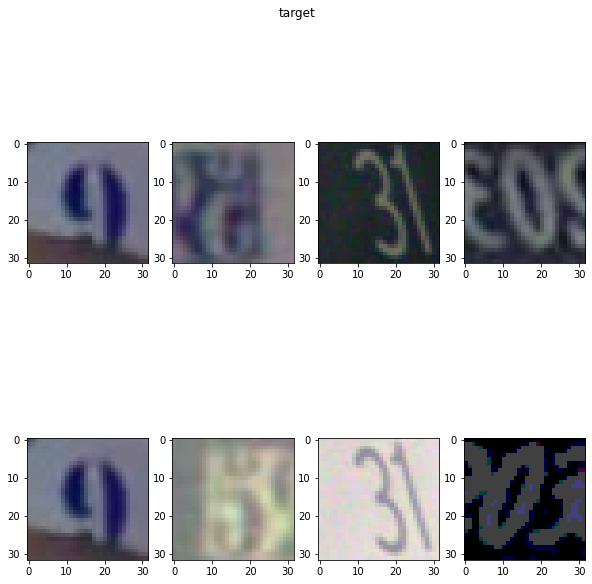

In [8]:
# draw augmented samples

import matplotlib.pyplot as plt
def draw_sample(ds, type):
    item = ds.take(1).get_single_element()
    w = item[0][0]
    s = item[1][0]
    fig = plt.figure(figsize=(10,10))
    for i in range(4):
        img = w[i].numpy().astype('uint8')
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(img)
        img = s[i].numpy().astype('uint8')
        ax = plt.subplot(2, 4, i+1 + 4)
        plt.imshow(img)
    fig.suptitle(type) 

draw_sample(final_source_ds, 'source')
draw_sample(final_target_ds, 'target')

In [9]:
def compute_loss_source(source_labels, logits_source_w, logits_source_s):
    loss_func = keras.losses.CategoricalCrossentropy(from_logits=True)
    w_loss = loss_func(source_labels, logits_source_w)
    s_loss = loss_func(source_labels, logits_source_s)
    return w_loss + s_loss

def compute_loss_target(target_pseudo_labels_w, logits_target_s, mask):
    loss_func = keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
    target_pseudo_labels_w = tf.stop_gradient(target_pseudo_labels_w)
    target_loss = loss_func(target_pseudo_labels_w, logits_target_s)

    mask = tf.cast(mask, target_loss.dtype)
    target_loss *= mask
    return tf.reduce_mean(target_loss, 0)
    

In [24]:
class AdaMatch(keras.Model):
    def __init__(self, model, total_steps, tau=0.9):
        super(AdaMatch, self).__init__()
        self.model = model
        self.tau = tau
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.total_steps = total_steps
        self.current_step = tf.Variable(0, dtype='int64')

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_mu(self):
        pi = tf.constant(np.pi, dtype='float32')
        step = tf.cast(self.current_step, dtype='float32')
        return 0.5 - tf.cos(tf.math.minimum(pi, (2 * pi * step) / self.total_steps)) / 2

    def train_step(self, data):
        source_ds, target_ds = data
        (source_w, source_labels), (source_s, _) = source_ds
        (
            (target_w, _),
            (target_s, _),
        ) = target_ds

        combined_images = tf.concat([source_w, source_s, target_w, target_s], 0)
        combined_source = tf.concat([source_w, source_s], 0)

        total_source = tf.shape(combined_source)[0]
        total_target = tf.shape(tf.concat([target_w, target_s], 0))[0]

        with tf.GradientTape() as tape:

            combined_logits = self.model(combined_images, training=True)
            z_d_prime_source = self.model(
                combined_source, training=False
            )
            z_prime_source = combined_logits[:total_source]


            # Random logit interpolation.
            lambd = tf.random.uniform((total_source, 10), 0, 1)
            final_source_logits = (lambd * z_prime_source) + (1 - lambd) * z_d_prime_source


            # Distribution alignment. it is applied for only weak augmented data
            y_hat_source_w = tf.nn.softmax(final_source_logits[: tf.shape(source_w)[0]])

            logits_target = combined_logits[total_source:]
            logits_target_w = logits_target[: tf.shape(target_w)[0]]
            y_hat_target_w = tf.nn.softmax(logits_target_w)

            expectation_ratio = tf.reduce_mean(y_hat_source_w) / tf.reduce_mean(
                y_hat_target_w
            )

            y_tilde_target_w = tf.math.l2_normalize(
                y_hat_target_w * expectation_ratio, 1
            )

            # relative confidence threshold
            row_wise_max = tf.reduce_max(y_hat_source_w, axis = -1)
            final_sum = tf.reduce_mean(row_wise_max, 0)
            c_tau = self.tau * final_sum
            mask = tf.reduce_max(y_tilde_target_w, axis=-1) >= c_tau

            # compute loss
            source_loss = compute_loss_source(
                source_labels,
                final_source_logits[: tf.shape(source_w)[0]],
                final_source_logits[tf.shape(source_w)[0] :],
            )

            target_loss = compute_loss_target(
                y_tilde_target_w, logits_target[tf.shape(target_w)[0]:], mask
            )

            t = self.compute_mu()
            total_loss = source_loss + (t * target_loss)
            self.current_step.assign_add(
                1
            )
        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.loss_tracker.update_state(total_loss)

        return {'loss': self.loss_tracker.result()}


In [11]:
# instantiate a backbone model. wide-resnet-28-2

def wide_basic(x, n_input_plane, n_output_plane, stride):
    conv_params = [[3, 3, stride, 'same'], [3, 3, (1, 1), 'same']]

    n_bottleneck_plane = n_output_plane

    for i, v in enumerate(conv_params):
        if i == 0:
            if n_input_plane != n_output_plane:
                x = layers.BatchNormalization()(x)
                x = layers.Activation('relu')(x)
                convs = x
            else:
                convs = layers.BatchNormalization()(x)
                convs = layers.Activation('relu')(convs)

            convs = layers.Conv2D(
                n_bottleneck_plane,
                (v[0], v[1]),
                strides=v[2],
                padding=v[3],
                kernel_initializer = init,
                kernel_regularizer = regularizers.l2(weight_decay)
            )(convs)

        else:
            convs = layers.BatchNormalization()(convs)
            convs = layers.Activation('relu')(convs)
            convs = layers.Conv2D(
                n_bottleneck_plane,
                (v[0], v[1]),
                strides=v[2],
                padding=v[3],
                kernel_initializer = init,
                kernel_regularizer = regularizers.l2(weight_decay)
            )(convs)

    if n_input_plane != n_output_plane:
        shortcut = layers.Conv2D(
            n_output_plane,
            (1, 1),
            strides=stride,
            padding='same',
            kernel_initializer = init,
            kernel_regularizer = regularizers.l2(weight_decay),
            use_bias = False,
        )(x)
    else:
        shortcut = x

    return layers.Add()([convs, shortcut])


def block_series(x, n_input_plane, n_output_plane, count, stride):
    x = wide_basic(x, n_input_plane, n_output_plane, stride)
    for i in range(2, int(count+1)):
        x = wide_basic(x, n_output_plane, n_output_plane, stride=1)
    
    return x

def get_network(image_size = 32, num_classes = 10):
    n = (depth - 4) / 6
    n_stages = [16, 16 * width_mult, 32 * width_mult, 64 * width_mult]

    inputs = keras.Input(shape = (image_size, image_size, 3))
    x = layers.Rescaling(scale= 1.0 / 255)(inputs)

    conv1 = layers.Conv2D(
        n_stages[0],
        (3, 3),
        strides = 1,
        padding = 'same',
        kernel_initializer = init,
        kernel_regularizer = regularizers.l2(weight_decay),
        use_bias = False,
    )(x)

    conv2 = block_series(
        conv1,
        n_input_plane = n_stages[0],
        n_output_plane = n_stages[1],
        count = n,
        stride = (1, 1),
    )
    
    conv3 = block_series(
    conv2,
    n_input_plane=n_stages[1],
    n_output_plane=n_stages[2],
    count=n,
    stride=(2, 2),
    )

    conv4 = block_series(
    conv3,
    n_input_plane=n_stages[2],
    n_output_plane=n_stages[3],
    count=n,
    stride=(2, 2),
    )

    batch_norm = layers.BatchNormalization()(conv4)
    relu = layers.Activation('relu')(batch_norm)

    trunk_outputs = layers.GlobalAveragePooling2D()(relu)
    outputs = layers.Dense(
        num_classes, kernel_regularizer = regularizers.l2(weight_decay)
    )(trunk_outputs)

    return keras.Model(inputs, outputs)


In [12]:
wrn_model = get_network()
wrn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                   

In [25]:
reduce_lr = keras.optimizers.schedules.CosineDecay(learning_rate, total_steps, 0.25)
optimizer = keras.optimizers.Adam(reduce_lr)

adamatch_trainer = AdaMatch(model=wrn_model, total_steps=total_steps)
adamatch_trainer.compile(optimizer=optimizer)

In [26]:
total_ds = tf.data.Dataset.zip((final_source_ds, final_target_ds))
adamatch_trainer.fit(total_ds, epochs=epochs)

Epoch 1/10


AttributeError: in user code:

    File "d:\Strad\Personal\venv\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "d:\Strad\Personal\venv\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Strad\Personal\venv\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_58000\1936520474.py", line 63, in train_step
        row_wise_max = tf.reudce_max(y_hat_source_w, axis = -1)

    AttributeError: module 'tensorflow' has no attribute 'reudce_max'
